<h1>Load Dataset</h1>

In [2]:
import tensorflow as tf
from keras import utils, layers
from keras.layers import Dense,Dropout,BatchNormalization
from keras.optimizers import Adamax
from keras.metrics import categorical_crossentropy
from keras import regularizers
from keras.models import Model
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, TensorBoard
import numpy as np
import datetime
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [3]:
img_height = 224
img_width = 224
num_classes = 4
batch_size = 16

In [4]:
data_train = utils.image_dataset_from_directory(
    'clean_dataset/train',
    labels='inferred',
    label_mode='int',
    class_names=['0','1','2','3'],
    color_mode='rgb',
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 1572 files belonging to 4 classes.


In [5]:
data_val = utils.image_dataset_from_directory(
    'clean_dataset/val',
    labels='inferred',
    label_mode='int',
    class_names=['0','1','2','3'],
    color_mode='rgb',
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 332 files belonging to 4 classes.


In [6]:
data_test = utils.image_dataset_from_directory(
    'clean_dataset/test',
    labels='inferred',
    label_mode='int',
    class_names=['0','1','2','3'],
    color_mode='rgb',
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 332 files belonging to 4 classes.


In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train = data_train.cache().prefetch(buffer_size=AUTOTUNE)
val = data_val.cache().prefetch(buffer_size=AUTOTUNE)
test = data_test.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
for image_batch, labels_batch in data_train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 224, 224, 3)
(16,)


<h1>Visualization of Samples</h1>

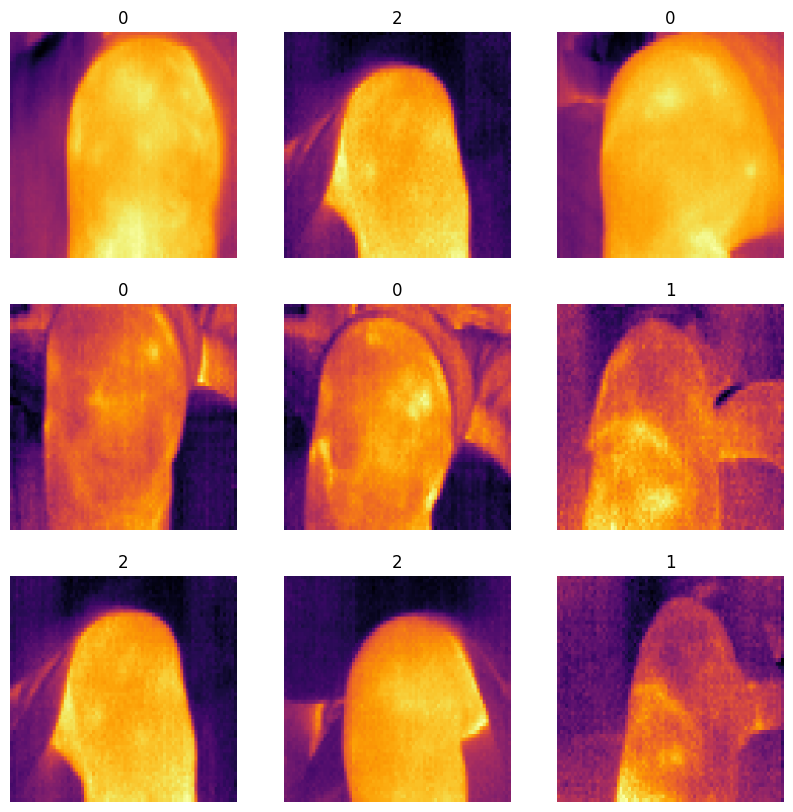

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in data_train.take(1): 
  num_images_to_show = 9
  for i in range(num_images_to_show):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(data_train.class_names[labels[i]])
    plt.axis("off")
plt.show()

<h1>Neural Network Architecture</h1>

In [10]:
metrics = ['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]

In [29]:
img_shape=(img_height, img_width, 3)
inputs = tf.keras.Input(shape=img_shape)
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.GaussianNoise(0.02)
])
x = data_augmentation(inputs)


base_model=tf.keras.applications.MobileNetV3Small(include_top=False, weights="imagenet", pooling='max', input_shape=img_shape)
base_model.trainable=False

x=base_model.output
x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(10, kernel_regularizer = regularizers.l2(l = 0.03),activity_regularizer=regularizers.l1(0.02),
        bias_regularizer=regularizers.l1(0.02) ,activation='relu')(x)
x=Dropout(rate=.4)(x)


lr=.0001
outputs=Dense(num_classes, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=outputs)
model.compile(Adamax(learning_rate=lr), loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

In [30]:
logdir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=logdir, histogram_freq=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)
epochs = 100
history = model.fit(train,
                    validation_data=val,
                    epochs=epochs,
                    verbose=1,
                    callbacks=[early_stopping,tensorboard_callback])

Epoch 1/100
99/99 [==============================] - 8s 54ms/step - loss: 2.4975 - accuracy: 0.3168 - val_loss: 2.6692 - val_accuracy: 0.3163
Epoch 2/100
99/99 [==============================] - 3s 32ms/step - loss: 2.2783 - accuracy: 0.3677 - val_loss: 2.0448 - val_accuracy: 0.4428
Epoch 3/100
99/99 [==============================] - 3s 32ms/step - loss: 2.1238 - accuracy: 0.4090 - val_loss: 1.8177 - val_accuracy: 0.5693
Epoch 4/100
99/99 [==============================] - 3s 33ms/step - loss: 2.0059 - accuracy: 0.4504 - val_loss: 1.6842 - val_accuracy: 0.6325
Epoch 5/100
99/99 [==============================] - 4s 36ms/step - loss: 1.8996 - accuracy: 0.4905 - val_loss: 1.5900 - val_accuracy: 0.6596
Epoch 6/100
99/99 [==============================] - 4s 40ms/step - loss: 1.8206 - accuracy: 0.4962 - val_loss: 1.5145 - val_accuracy: 0.6928
Epoch 7/100
99/99 [==============================] - 3s 31ms/step - loss: 1.7314 - accuracy: 0.5350 - val_loss: 1.4521 - val_accuracy: 0.7078
Epoch 

<h1>Metrics</h1>

In [24]:
loss, accuracy = model.evaluate(test)

21/21 [==============================] - 1s 16ms/step - loss: 0.4778 - accuracy: 0.9819


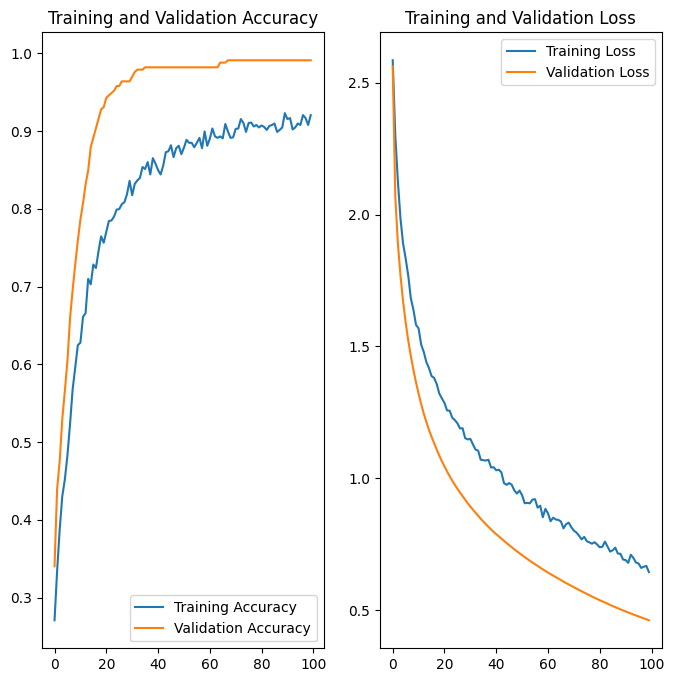

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [25]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import numpy as np
import tensorflow as tf

DEFAULT_FUNCTION_KEY = 'serving_default'
MODEL_PATH = 'tf-osteo' 


    
try:
    model: tf.saved_model = tf.saved_model.load(MODEL_PATH)
    inference_func = model.signatures[DEFAULT_FUNCTION_KEY]
    print(f"Model loaded successfully from {MODEL_PATH}")
except Exception as e:
    print(f"Error loading model from {MODEL_PATH}: {e}")
    inference_func = None

Model loaded successfully from tf-osteo


AttributeError: '_UserObject' object has no attribute 'predict_on_batch'

In [16]:
tf.saved_model.save(model, "tf-osteo")

INFO:tensorflow:Assets written to: tf-osteo\assets


INFO:tensorflow:Assets written to: tf-osteo\assets
